# DATASET ABALONE

- Ant√¥nio Joabe
- Jo√£o Pedro
- J√¥natas Brito

In [44]:
!pip install pandas
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering


# Objetivo: importar bibliotecas essenciais para an√°lise, visualiza√ß√£o e normaliza√ß√£o dos dados.


## Carregamento e informa√ß√µes do Dataset

In [46]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 
                'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 
                'ShellWeight', 'Rings']

df = pd.read_csv("abalone.data", header=None, names=column_names)

# Carregamento do arquivo `abalone.data` com nomes de colunas definidos

In [47]:
df.head()


Sex  Length  Diameter  Height  WholeWeight  ShuckedWeight  VisceraWeight  \
0   M   0.455     0.365   0.095       0.5140         0.2245         0.1010   
1   M   0.350     0.265   0.090       0.2255         0.0995         0.0485   
2   F   0.530     0.420   0.135       0.6770         0.2565         0.1415   
3   M   0.440     0.365   0.125       0.5160         0.2155         0.1140   
4   I   0.330     0.255   0.080       0.2050         0.0895         0.0395   

   ShellWeight  Rings  
0        0.150     15  
1        0.070      7  
2        0.210      9  
3        0.155     10  
4        0.055      7

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   object 
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [49]:
df.describe()

Length     Diameter       Height  WholeWeight  ShuckedWeight  \
count  4177.000000  4177.000000  4177.000000  4177.000000    4177.000000   
mean      0.523992     0.407881     0.139516     0.828742       0.359367   
std       0.120093     0.099240     0.041827     0.490389       0.221963   
min       0.075000     0.055000     0.000000     0.002000       0.001000   
25%       0.450000     0.350000     0.115000     0.441500       0.186000   
50%       0.545000     0.425000     0.140000     0.799500       0.336000   
75%       0.615000     0.480000     0.165000     1.153000       0.502000   
max       0.815000     0.650000     1.130000     2.825500       1.488000   

       VisceraWeight  ShellWeight        Rings  
count    4177.000000  4177.000000  4177.000000  
mean        0.180594     0.238831     9.933684  
std         0.109614     0.139203     3.224169  
min         0.000500     0.001500     1.000000  
25%         0.093500     0.130000     8.000000  
50%         0.171000     0.234000     9.000000  
75%         0.253000     0.329000    11.000000  
max         0.760000     1.005000    29.000000

In [50]:
df.isnull().sum()

# Confirma√ß√£o se h√° ou n√£o valores nulos no dataset

Sex              0
Length           0
Diameter         0
Height           0
WholeWeight      0
ShuckedWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


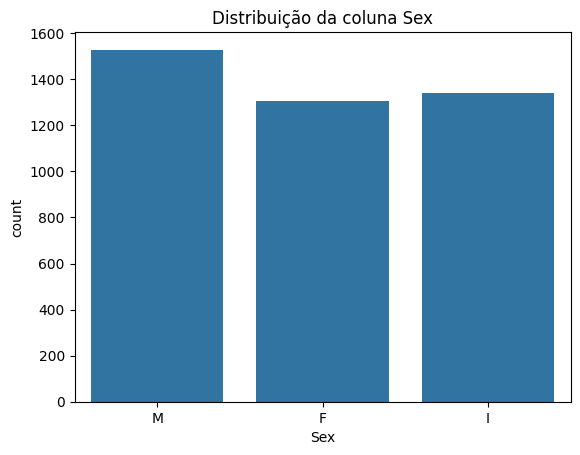

In [51]:
print(df['Sex'].value_counts())

sns.countplot(x='Sex', data=df)
plt.title('Distribui√ß√£o da coluna Sex')
plt.show()

# Visualiza√ß√£o da distribui√ß√£o das categorias M, F e I (infant)


## Visualiza√ß√£o dos Outliers

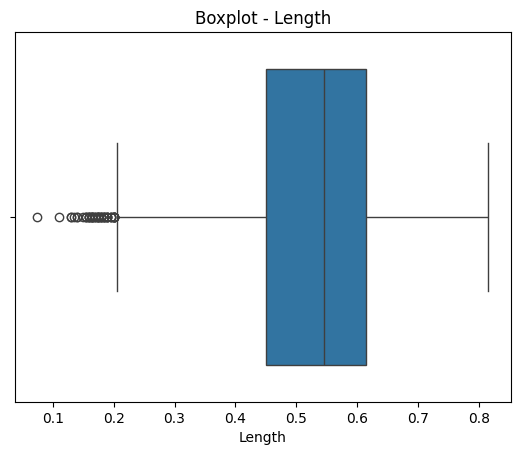

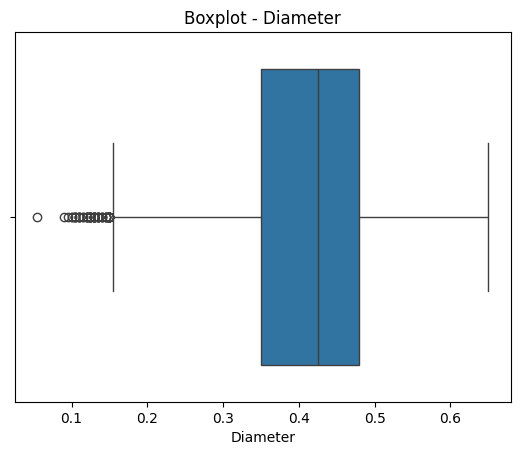

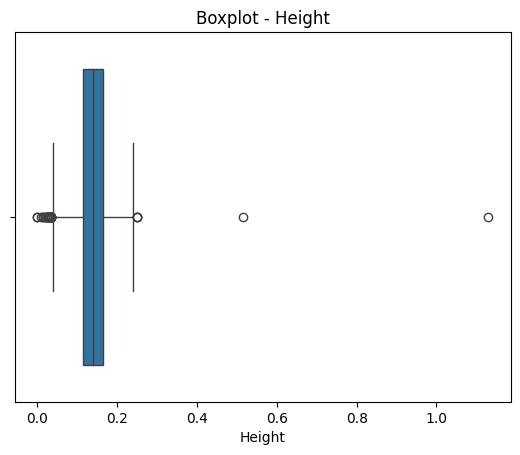

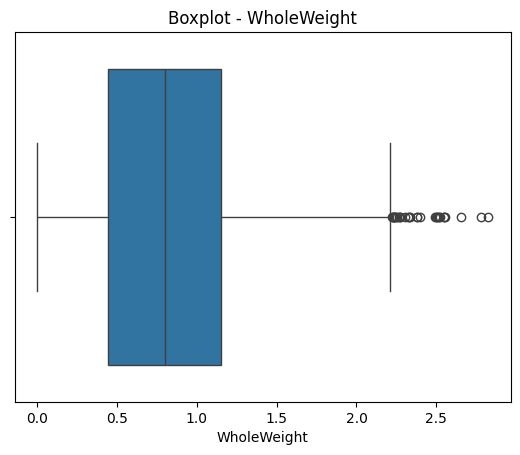

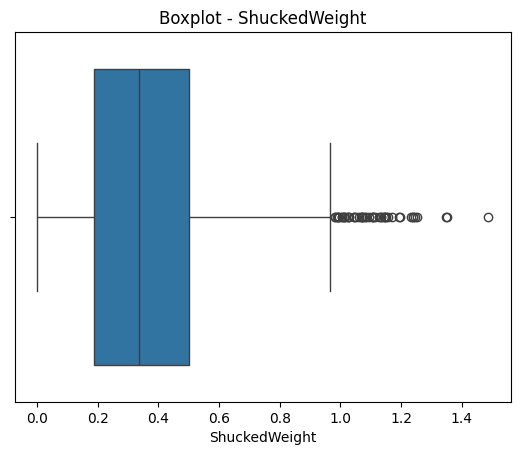

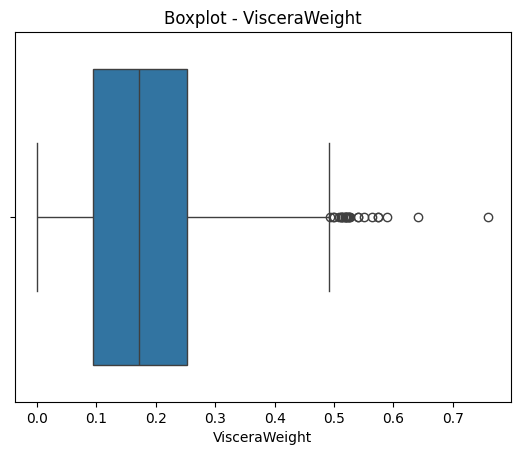

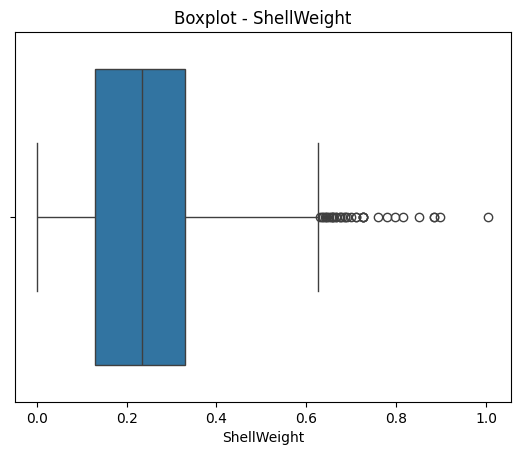

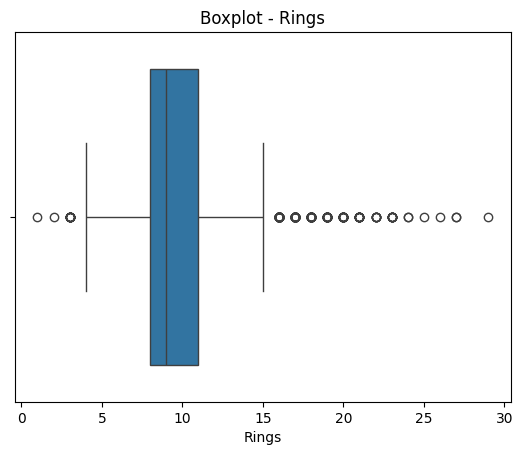

In [52]:
num_features = df.columns[1:]
for col in num_features:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot - {col}')
    plt.show()

# Gera√ß√£o de boxplots para cada vari√°vel num√©rica para a visualiza√ß√£o de outliers


In [53]:
df_clean = df.copy()

numeric_features = ['Length', 'Diameter', 'Height', 
                'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 
                'ShellWeight',]
categorical_features = ['Sex']

#Organiza√ß√£o de dos dados em listas para serem tratados separadamente


## Tratamento dos Outliers

In [54]:
# Fun√ß√£o para remover outliers com base no m√©todo IQR (intervalo interquartil)
# Apenas mant√©m as linhas onde todos os valores num√©ricos est√£o dentro dos limites definidos
def remove_outliers_iqr_corrigido(df, columns):
    df_out = df.copy()

    limites = {}
    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        limites[col] = (limite_inferior, limite_superior)

    # Uma linha √© mantida se TODOS os seus valores estiverem dentro dos respectivos limites.
    mascara_outliers = pd.Series([True] * len(df_out), index=df_out.index)
    for col in columns:
        lim_inf, lim_sup = limites[col]
        mascara_outliers &= (df_out[col] >= lim_inf) & (df_out[col] <= lim_sup)

    return df_out[mascara_outliers]

print(f"Tamanho original do DataFrame: {df.shape}")
df_clean = remove_outliers_iqr_corrigido(df_clean, numeric_features)
print(f"Tamanho do DataFrame ap√≥s remo√ß√£o de outliers: {df_clean.shape}")

Tamanho original do DataFrame: (4177, 9)
Tamanho do DataFrame ap√≥s remo√ß√£o de outliers: (4024, 9)


## Pr√©-Processamento

In [55]:
# Define um preprocessador para normalizar os dados num√©ricos e transformar as categorias em one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
)

# Aplica o transformador ao subconjunto do DataFrame com colunas selecionadas
df_for_transforming = df_clean[numeric_features+categorical_features]
X_processed = preprocessor.fit_transform(df_for_transforming)

new_columns = preprocessor.get_feature_names_out()

df_processed_scaled = pd.DataFrame(X_processed, columns=new_columns)

new_columns_with_prefix = preprocessor.get_feature_names_out()

cleaned_columns = [col.split('__')[1] for col in new_columns_with_prefix]

df_processed_scaled = pd.DataFrame(X_processed, columns=cleaned_columns)

df_processed_scaled.head()


Length  Diameter   Height  WholeWeight  ShuckedWeight  VisceraWeight  \
0 -0.632245 -0.474574 -1.23997    -0.666150      -0.631483      -0.753592   
1 -1.580579 -1.562434 -1.38003    -1.310363      -1.251442      -1.270933   
2  0.045136  0.123750 -0.11949    -0.302174      -0.472773      -0.354500   
3 -0.767721 -0.474574 -0.39961    -0.661684      -0.676120      -0.625488   
4 -1.761214 -1.671220 -1.66015    -1.356139      -1.301038      -1.359620   

   ShellWeight  Sex_F  Sex_I  Sex_M  
0    -0.665126    0.0    0.0    1.0  
1    -1.296032    0.0    0.0    1.0  
2    -0.191946    1.0    0.0    0.0  
3    -0.625694    0.0    0.0    1.0  
4    -1.414327    0.0    1.0    0.0

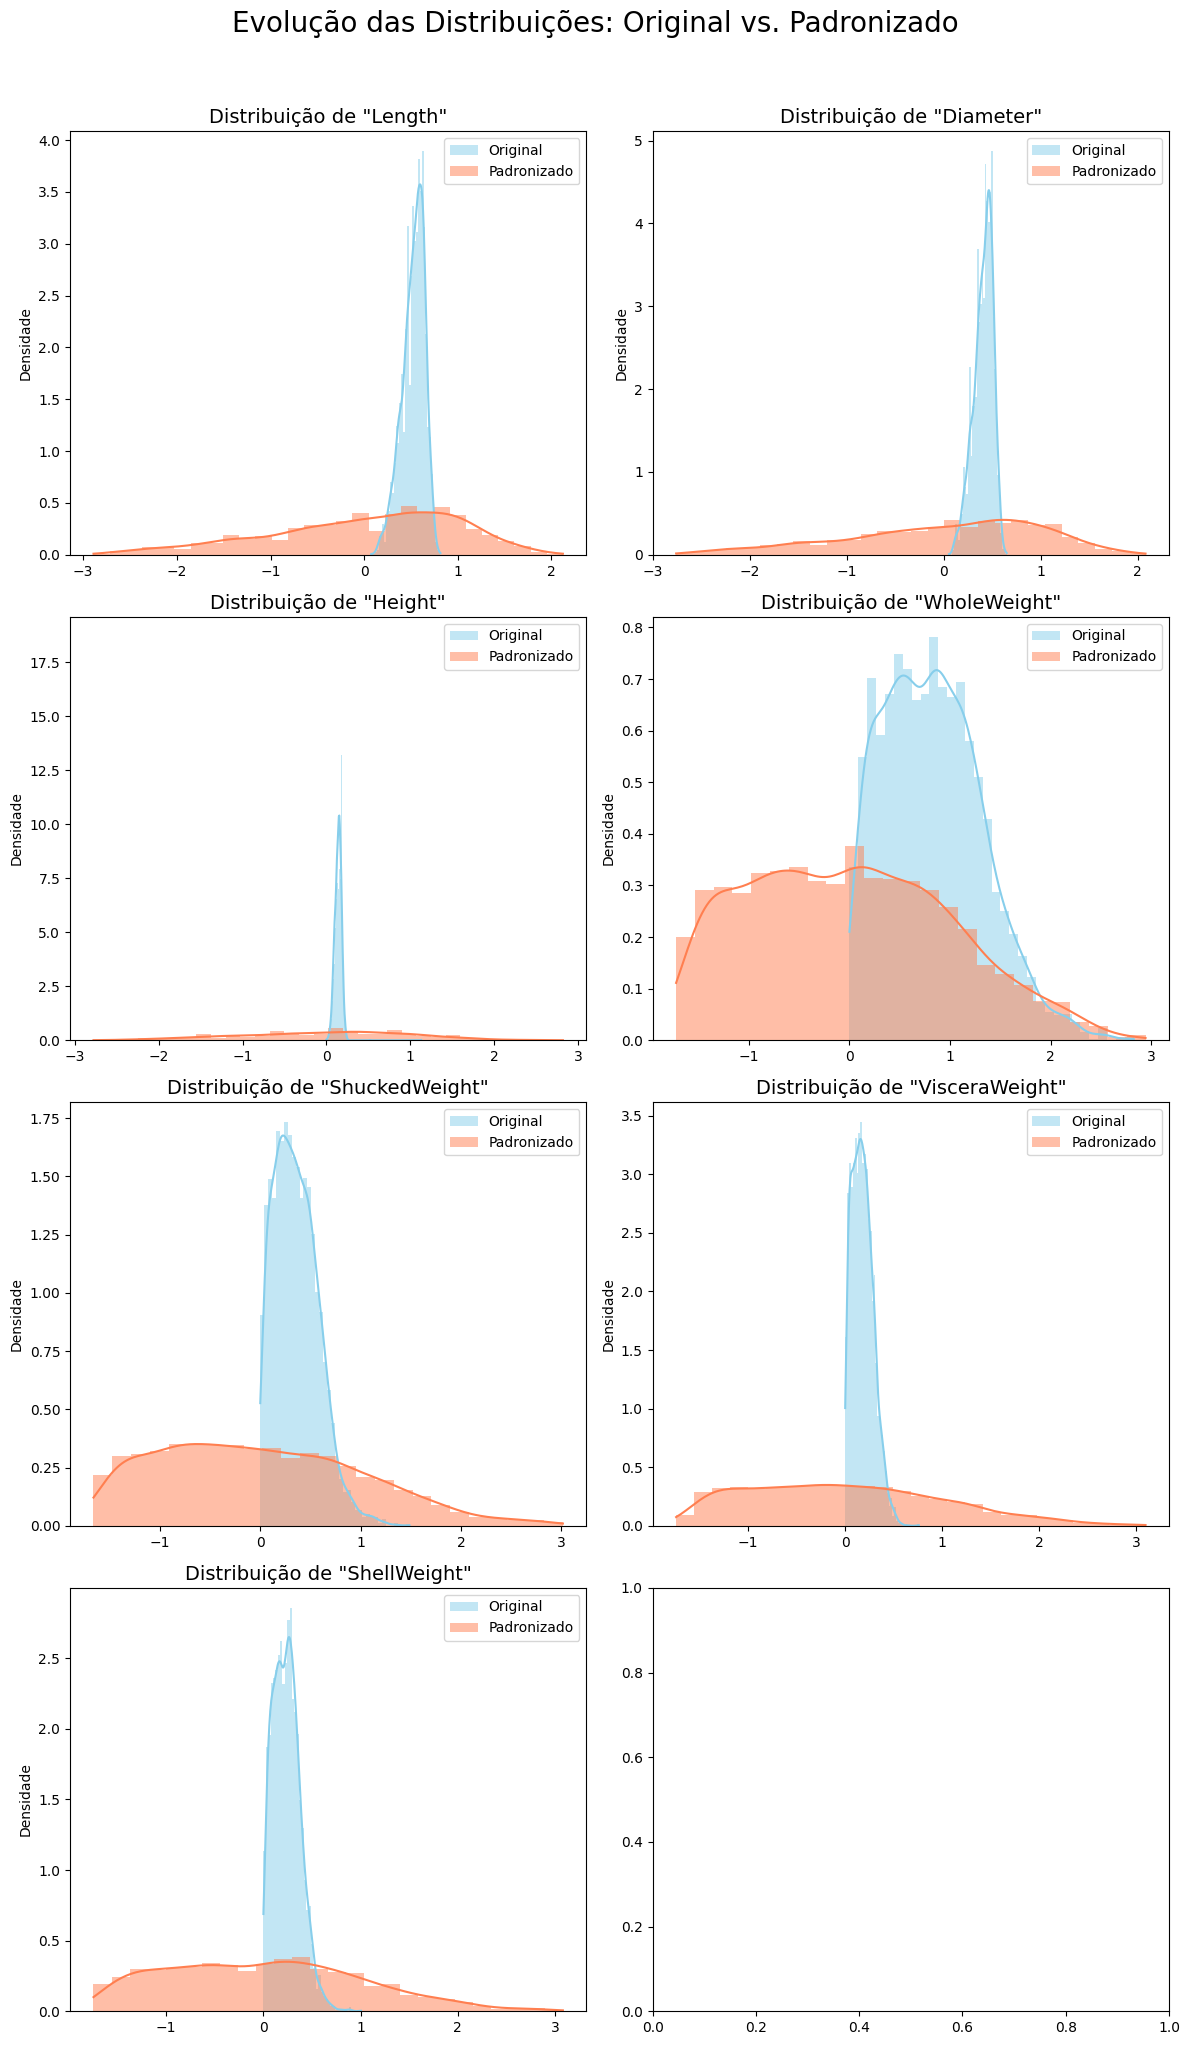

In [56]:

# Cria√ß√£o dos gr√°ficos para compara√ß√£o das distribui√ß√µes
n_features = len(numeric_features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    ax = axes[i]
    sns.histplot(data=df, x=feature, color="skyblue", label='Original', kde=True, ax=ax, stat="density", linewidth=0)
    sns.histplot(data=df_processed_scaled, x=feature, color="coral", label='Padronizado', kde=True, ax=ax, stat="density", linewidth=0)
    ax.set_title(f'Distribui√ß√£o de "{feature}"', fontsize=14)
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('Densidade')

fig.suptitle('Evolu√ß√£o das Distribui√ß√µes: Original vs. Padronizado', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

/home/jonatas-brito/Trabalho-ML-2/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


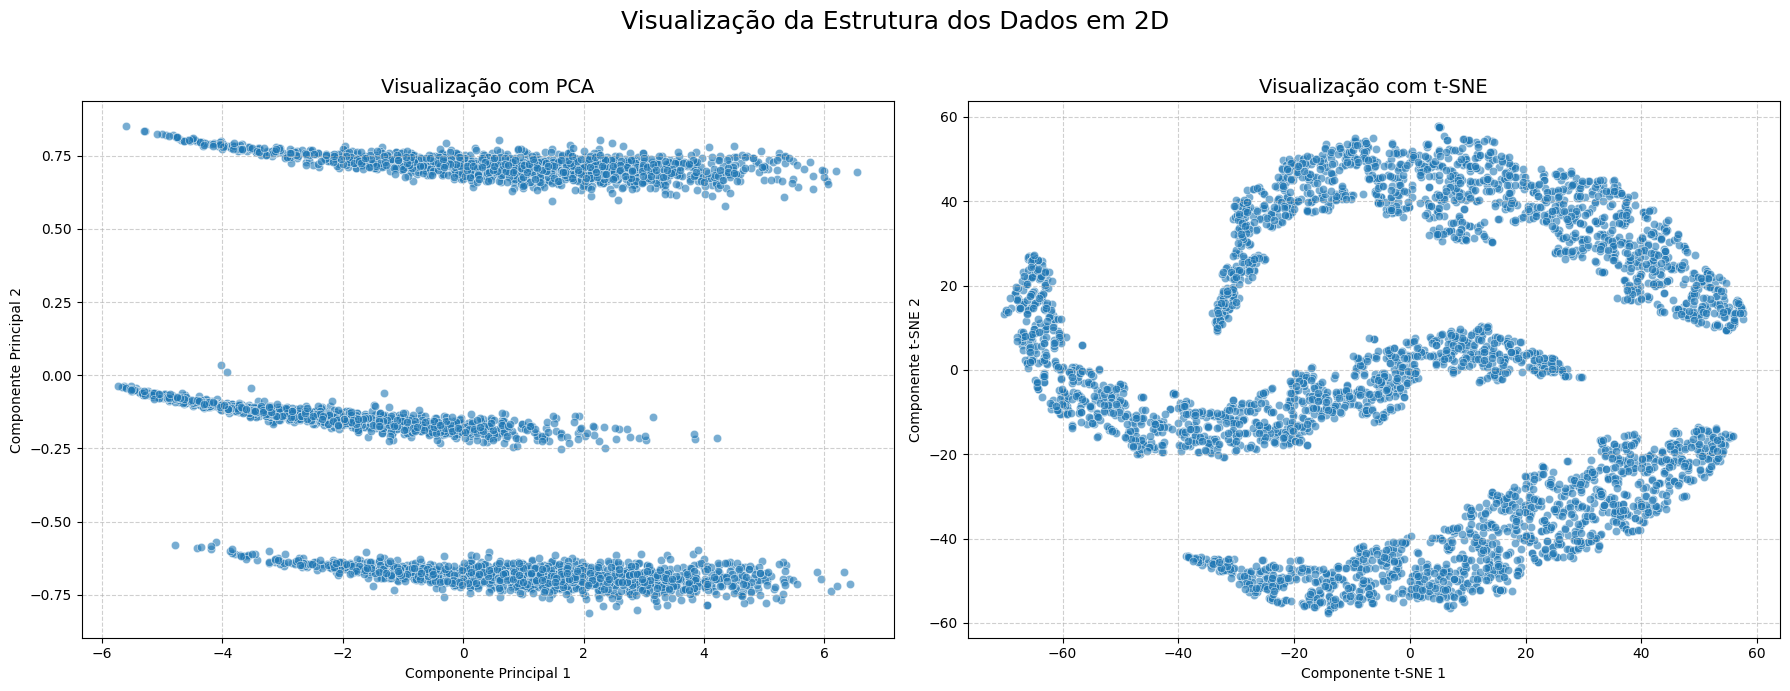

In [57]:
pca = PCA(n_components=2, random_state=42)
coordenadas_pca = pca.fit_transform(df_processed_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
coordenadas_tsne = tsne.fit_transform(df_processed_scaled)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

fig.suptitle('Visualiza√ß√£o da Estrutura dos Dados em 2D', fontsize=18)

#PCA
sns.scatterplot(x=coordenadas_pca[:, 0], y=coordenadas_pca[:, 1], ax=axes[0], alpha=0.6)
axes[0].set_title('Visualiza√ß√£o com PCA', fontsize=14)
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')
axes[0].grid(True, linestyle='--', alpha=0.6)

#t-SNE
sns.scatterplot(x=coordenadas_tsne[:, 0], y=coordenadas_tsne[:, 1], ax=axes[1], alpha=0.6)
axes[1].set_title('Visualiza√ß√£o com t-SNE', fontsize=14)
axes[1].set_xlabel('Componente t-SNE 1')
axes[1].set_ylabel('Componente t-SNE 2')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# K-MEANS (J√¥natas)

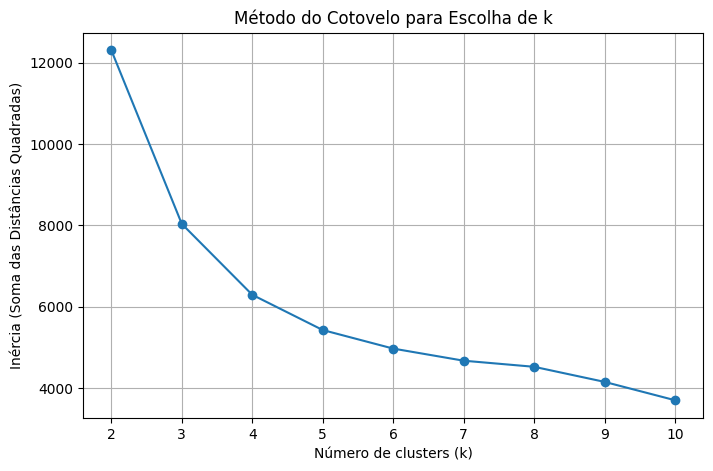

In [58]:
inertia = []
K_range = range(2, 11)

# La√ßo que mostra a in√©rcia (soma das dist√¢ncias quadradas) para cada n√∫mero de clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_processed_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('N√∫mero de clusters (k)')
plt.ylabel('In√©rcia (Soma das Dist√¢ncias Quadradas)')
plt.title('M√©todo do Cotovelo para Escolha de k')
plt.grid(True)
plt.show()

# O "cotovelo" indica onde a melhoria se estabiliza.

In [59]:
best_k = 3  # (Valor escolhido ap√≥s an√°lise do gr√°fico do m√©todo do cotovelo)
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(df_processed_scaled) # Aplica o modelo k-means aos dados padronizados
centroids = kmeans.cluster_centers_ # Calcula os centr√≥ides dos clusters



In [60]:
sil_score_kmeans = silhouette_score(df_processed_scaled, labels)
db_score_kmeans = davies_bouldin_score(df_processed_scaled, labels)
ch_score_kmeans = calinski_harabasz_score(df_processed_scaled, labels)

print(f"Silhouette Score: {sil_score_kmeans:.3f}")
print(f"Davies-Bouldin Score: {db_score_kmeans:.3f}")
print(f"Calinski-Harabasz Score: {ch_score_kmeans:.3f}")

# Interpreta√ß√£o:
# Silhouette Score avalia coes√£o e separa√ß√£o (-1 a 1)
# Davies-Bouldin mede similaridade entre clusters (quanto menor, melhor)
# Calinski-Harabasz avalia a raz√£o entre dispers√£o entre e dentro dos clusters (quanto maior, melhor)


Silhouette Score: 0.382
Davies-Bouldin Score: 0.887
Calinski-Harabasz Score: 5706.627


/home/jonatas-brito/Trabalho-ML-2/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/jonatas-brito/Trabalho-ML-2/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


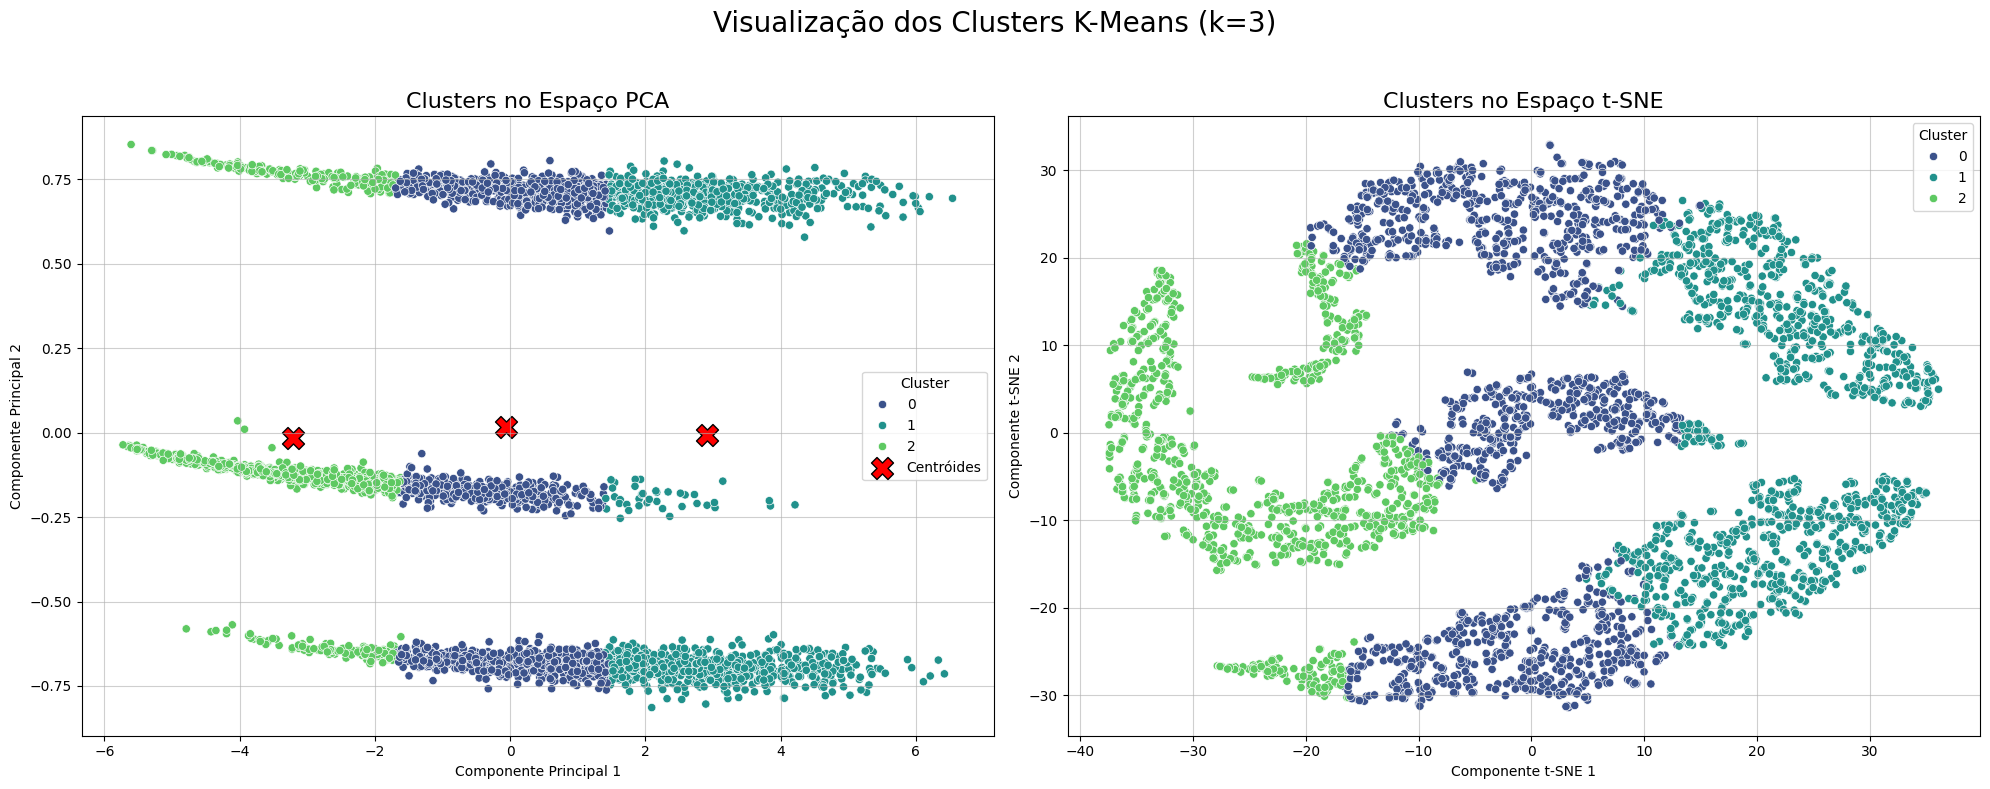

In [61]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculando o t-SNE (ajustado para performance)
tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
coordenadas_tsne = tsne.fit_transform(df_processed_scaled)

# Criando DataFrame para visualiza√ß√£o
df_plot_kmeans = pd.DataFrame()
df_plot_kmeans['PCA1'] = coordenadas_pca[:, 0]
df_plot_kmeans['PCA2'] = coordenadas_pca[:, 1]
df_plot_kmeans['TSNE1'] = coordenadas_tsne[:, 0]
df_plot_kmeans['TSNE2'] = coordenadas_tsne[:, 1]
df_plot_kmeans['Cluster'] = pd.Categorical(labels)

# Gr√°fico PCA + t-SNE
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Visualiza√ß√£o dos Clusters K-Means (k=3)', fontsize=20)

# PCA
sns.scatterplot(
    data=df_plot_kmeans,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    ax=axes[0]
)

# Centr√≥ides transformados com PCA
centroids_pca = pca.transform(kmeans.cluster_centers_)
axes[0].scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker='X',
    s=250,
    c='red',
    edgecolor='black',
    label='Centr√≥ides'
)
axes[0].set_title('Clusters no Espa√ßo PCA', fontsize=16)
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')
axes[0].legend(title='Cluster')
axes[0].grid(True, alpha=0.6)

# t-SNE
sns.scatterplot(
    data=df_plot_kmeans,
    x='TSNE1',
    y='TSNE2',
    hue='Cluster',
    palette='viridis',
    ax=axes[1]
)
axes[1].set_title('Clusters no Espa√ßo t-SNE', fontsize=16)
axes[1].set_xlabel('Componente t-SNE 1')
axes[1].set_ylabel('Componente t-SNE 2')
axes[1].legend(title='Cluster')
axes[1].grid(True, alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [62]:
# Usando o df_clean por ser o dataset original tratado sem os ru√≠dos
df_clean['Cluster'] = labels  #kmeans.fit_predict

# Agrupamos por cluster e calculamos a m√©dia das features num√©ricas
numeric_cols = df_clean.select_dtypes(include='number').columns
print("M√©dia dos Atributos Num√©ricos por Cluster:\n")
display(df_clean.groupby('Cluster')[numeric_cols].mean().round(2))

print("\n--- An√°lise Detalhada da Idade (Rings) por Cluster ---\n")
display(df_clean.groupby('Cluster')['Rings'].describe().round(2))


M√©dia dos Atributos Num√©ricos por Cluster:



Length  Diameter  Height  WholeWeight  ShuckedWeight  VisceraWeight  \
Cluster                                                                        
0          0.54      0.42    0.14         0.76           0.33           0.17   
1          0.64      0.50    0.18         1.34           0.58           0.29   
2          0.38      0.29    0.10         0.29           0.12           0.06   

         ShellWeight  Rings  Cluster  
Cluster                               
0               0.23  10.38      0.0  
1               0.38  11.57      1.0  
2               0.09   7.53      2.0


--- An√°lise Detalhada da Idade (Rings) por Cluster ---



count   mean   std  min   25%   50%   75%   max
Cluster                                                  
0        1595.0  10.38  2.84  6.0   8.0  10.0  12.0  23.0
1        1289.0  11.57  2.95  6.0  10.0  11.0  13.0  29.0
2        1140.0   7.53  2.05  3.0   6.0   7.0   8.0  19.0

### üß© Conclus√£o da Clusteriza√ß√£o com KMeans (k=3)

A **clusteriza√ß√£o KMeans** aplicada aos abalones revelou agrupamentos coerentes com a vari√°vel **target** (`Rings`), mostrando uma clara separa√ß√£o por idade e porte f√≠sico.

As interpreta√ß√µes dos clusters foram as seguintes:

- üî∑ **Cluster 1**: Representa os **abalones mais velhos**, com **maior tamanho e peso**.
- üü¶ **Cluster 0**: Agrupa os **abalones intermedi√°rios**, com caracter√≠sticas moderadas.
- üü¢ **Cluster 2**: Reflete os **abalones mais jovens**, com **menor porte f√≠sico** e **idade mais baixa**.

> üìå Os resultados indicam que o KMeans foi eficaz em identificar padr√µes reais de crescimento


# DBSCAN - Joabe

## Determinando os hiperpar√¢metros do DBSCAN

Valor de min_samples (2 * D): 20


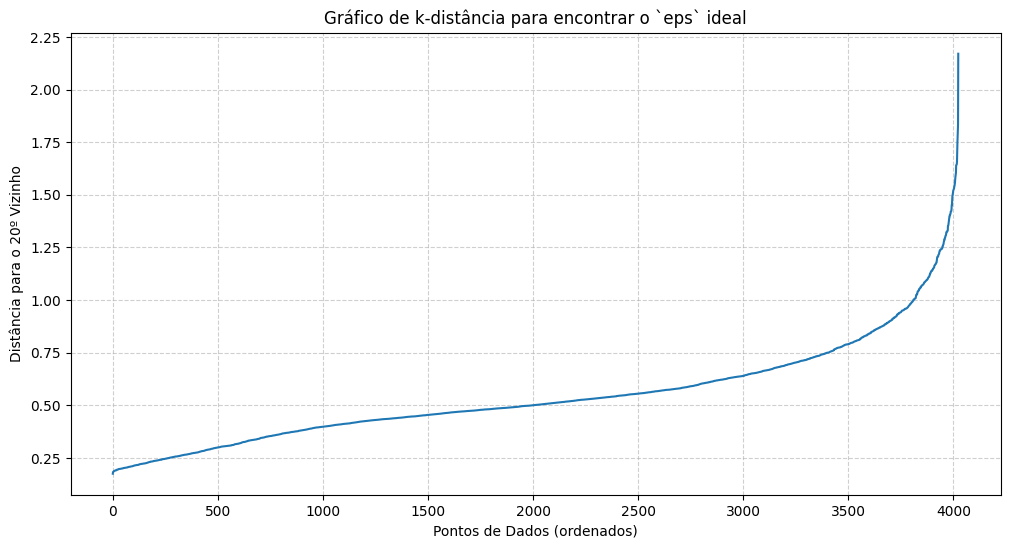

In [63]:
# 1. Definindo min_samples
D = df_processed_scaled.shape[1]
min_samples = 2*D
print(f"Valor de min_samples (2 * D): {min_samples}")

# 2. Encontrando o eps ideal com o gr√°fico de k-dist√¢ncia
k = min_samples
neighbors = NearestNeighbors(n_neighbors=k).fit(df_processed_scaled)
distances, indices = neighbors.kneighbors(df_processed_scaled)
k_distances = np.sort(distances[:, k-1], axis=0)

# Plotando o gr√°fico
plt.figure(figsize=(12, 6))
plt.plot(k_distances)
plt.title('Gr√°fico de k-dist√¢ncia para encontrar o `eps` ideal')
plt.xlabel('Pontos de Dados (ordenados)')
plt.ylabel(f'Dist√¢ncia para o {k}¬∫ Vizinho')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [64]:
# Com base no gr√°fico, um valor em torno de 1.4 parece ser o ponto de cotovelo.
eps_escolhido = 1.2
print(f"\nValor de `eps` escolhido a partir do gr√°fico: {eps_escolhido}")


Valor de `eps` escolhido a partir do gr√°fico: 1.2


## Treinamento e An√°lise do Modelo DBSCAN

In [65]:
# Instanciando e treinando o modelo DBSCAN
dbscan = DBSCAN(eps=eps_escolhido, min_samples=min_samples)
clusters_dbscan = dbscan.fit_predict(df_processed_scaled)

# Analisando os resultados
n_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

print(f"N√∫mero de clusters encontrados: {n_clusters}")
print(f"N√∫mero de pontos de ru√≠do (outliers): {n_noise}")
print("\nContagem de pontos por cluster:")
print(pd.Series(clusters_dbscan).value_counts())

N√∫mero de clusters encontrados: 3
N√∫mero de pontos de ru√≠do (outliers): 10

Contagem de pontos por cluster:
 0    1464
 2    1282
 1    1268
-1      10
Name: count, dtype: int64


## Avalia√ß√£o e Visualiza√ß√£o dos Clusters

In [66]:
core_points_mask = clusters_dbscan != -1 #Excluindo o ru√≠do para calcular as m√©tricas
labels_core_points = clusters_dbscan[core_points_mask]
data_core_points = df_processed_scaled[core_points_mask]

sil_score_dbscan = silhouette_score(data_core_points, labels_core_points)
db_score_dbscan = davies_bouldin_score(data_core_points, labels_core_points)
ch_score_dbscan = calinski_harabasz_score(data_core_points, labels_core_points)

print(f"\nSilhouette Score: {sil_score_dbscan:.4f}")
print(f"Davies-Bouldin Score: {db_score_dbscan:.4f}")
print(f"Calinski-Harabasz Score: {ch_score_dbscan:.2f}")


Silhouette Score: 0.1667
Davies-Bouldin Score: 2.1691
Calinski-Harabasz Score: 1167.07


‚Ä¢ Silhouette Score (0.1667): Baixo - clusters pouco definidos
‚Ä¢ Davies-Bouldin Score (2.1691): Alto - clusters sobrepostos
‚Ä¢ Calinski-Harabasz Score (1167.07): Moderado - defini√ß√£o razo√°vel

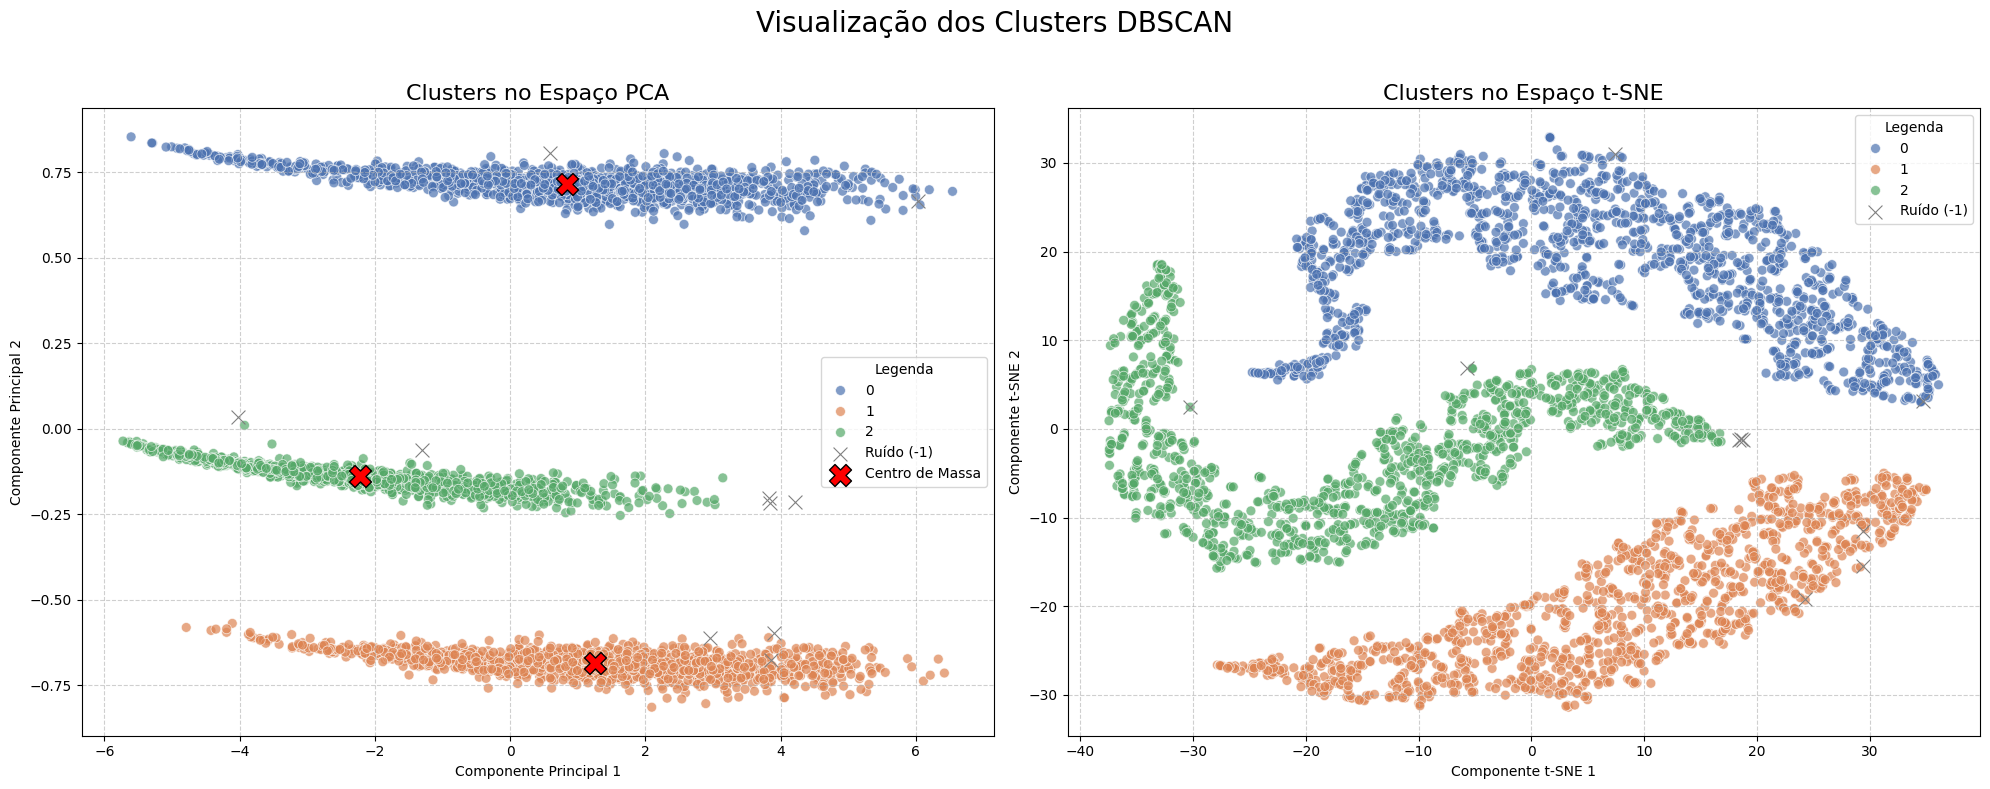

In [67]:
df_plot_dbscan = pd.DataFrame()
df_plot_dbscan['PCA1'] = coordenadas_pca[:, 0]
df_plot_dbscan['PCA2'] = coordenadas_pca[:, 1]
df_plot_dbscan['TSNE1'] = coordenadas_tsne[:, 0]
df_plot_dbscan['TSNE2'] = coordenadas_tsne[:, 1]
df_plot_dbscan['Cluster'] = clusters_dbscan

df_clusters = df_plot_dbscan[df_plot_dbscan['Cluster'] != -1]
df_noise = df_plot_dbscan[df_plot_dbscan['Cluster'] == -1]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Visualiza√ß√£o dos Clusters DBSCAN', fontsize=20)

ax_pca = axes[0]
sns.scatterplot(
    data=df_clusters, x='PCA1', y='PCA2', hue='Cluster',
    palette='deep', ax=ax_pca, s=50, alpha=0.7
)
sns.scatterplot(
    data=df_noise, x='PCA1', y='PCA2', color='gray',
    marker='x', s=100, ax=ax_pca, label='Ru√≠do (-1)'
)

# Centroides
centroids_pca = df_clusters.groupby('Cluster')[['PCA1', 'PCA2']].mean()
ax_pca.scatter(
    centroids_pca['PCA1'], centroids_pca['PCA2'],
    marker='X', s=250, c='red', edgecolor='black', label='Centro de Massa'
)
ax_pca.set_title('Clusters no Espa√ßo PCA', fontsize=16)
ax_pca.set_xlabel('Componente Principal 1')
ax_pca.set_ylabel('Componente Principal 2')
ax_pca.legend(title='Legenda')
ax_pca.grid(True, linestyle='--', alpha=0.6)

# --- Gr√°fico da Direita: t-SNE ---
ax_tsne = axes[1]
sns.scatterplot(
    data=df_clusters, x='TSNE1', y='TSNE2', hue='Cluster',
    palette='deep', ax=ax_tsne, s=50, alpha=0.7
)
sns.scatterplot(
    data=df_noise, x='TSNE1', y='TSNE2', color='gray',
    marker='x', s=100, ax=ax_tsne, label='Ru√≠do (-1)'
)
ax_tsne.set_title('Clusters no Espa√ßo t-SNE', fontsize=16)
ax_tsne.set_xlabel('Componente t-SNE 1')
ax_tsne.set_ylabel('Componente t-SNE 2')
ax_tsne.legend(title='Legenda')
ax_tsne.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## An√°lise dos Clusters

In [68]:
# Adiciona os r√≥tulos do DBSCAN ao DataFrame original
df_clean['Cluster'] = clusters_dbscan

# Filtra colunas num√©ricas para an√°lise estat√≠stica
numeric_cols = df_clean.select_dtypes(include='number').columns

# M√©dia dos atributos por cluster (ignorando outliers -1)
print("M√©dia dos Atributos Num√©ricos por Cluster:\n")
display(df_clean[df_clean['Cluster'] != -1].groupby('Cluster')[numeric_cols].mean().round(2))

# An√°lise detalhada da idade (Rings)
print("\n--- An√°lise Detalhada da Idade (Rings) por Cluster ---\n")
display(df_clean[df_clean['Cluster'] != -1].groupby('Cluster')['Rings'].describe().round(2))


M√©dia dos Atributos Num√©ricos por Cluster:



Length  Diameter  Height  WholeWeight  ShuckedWeight  VisceraWeight  \
Cluster                                                                        
0          0.56      0.44    0.15         0.95           0.42           0.21   
1          0.58      0.45    0.16         1.02           0.43           0.22   
2          0.44      0.33    0.11         0.44           0.20           0.09   

         ShellWeight  Rings  Cluster  
Cluster                               
0               0.27  10.66      0.0  
1               0.29  11.06      1.0  
2               0.13   8.03      2.0


--- An√°lise Detalhada da Idade (Rings) por Cluster ---



count   mean   std  min  25%   50%   75%   max
Cluster                                                 
0        1464.0  10.66  2.96  4.0  9.0  10.0  12.0  26.0
1        1268.0  11.06  3.05  5.0  9.0  10.0  12.0  29.0
2        1282.0   8.03  2.41  3.0  6.0   8.0   9.0  21.0

## An√°lise de correla√ß√£o com o Sexo do Abalone

In [69]:
pd.crosstab(clusters_dbscan, df_clean['Sex'], normalize='index').round(2)


Sex      F    I    M
row_0               
-1     0.3  0.5  0.2
 0     0.0  0.0  1.0
 1     1.0  0.0  0.0
 2     0.0  1.0  0.0

### üß© Conclus√£o Final: DBSCAN separou por sexo

A clusteriza√ß√£o com **DBSCAN** foi extremamente eficaz ao separar os dados dos abalones **por sexo** com 100% de pureza em cada cluster:

- üîµ **Cluster 0**: Exclusivamente **machos**
- üü£ **Cluster 1**: Exclusivamente **f√™meas**
- üü¢ **Cluster 2**: Exclusivamente **infantis**

> üìå Isso demonstra que as caracter√≠sticas f√≠sicas dos abalones s√£o fortemente determinadas pelo sexo, e que o DBSCAN capturou essas diferen√ßas

## üîó Clusteriza√ß√£o Hier√°rquica (Jo√£o Pedro)

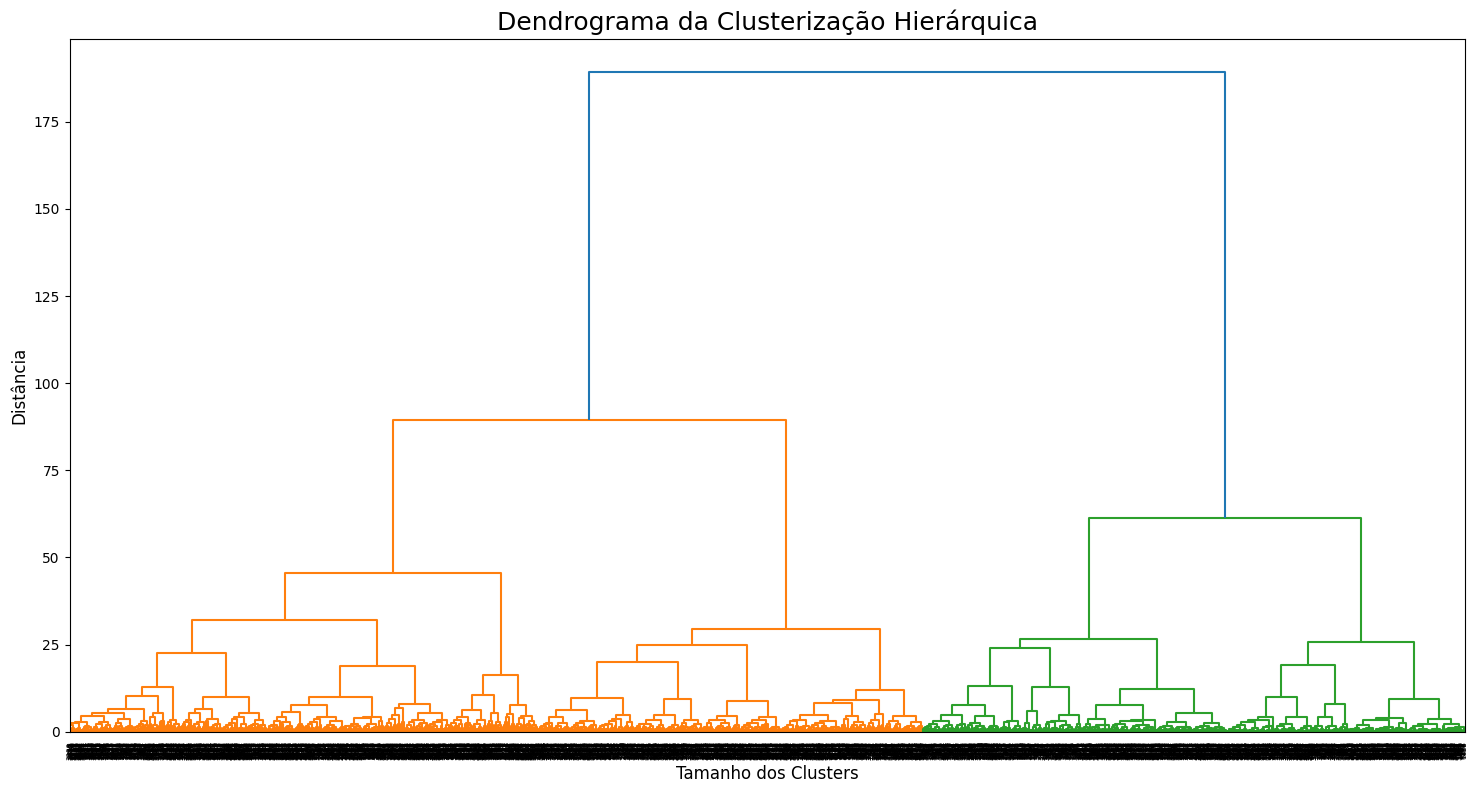

In [70]:
linked = linkage(df_processed_scaled, method='ward') # m√©todo ward para minimizar a vari√¢ncias dentro dos clusters

# Plotando o dendrograma
plt.figure(figsize=(18, 9))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)

plt.title('Dendrograma da Clusteriza√ß√£o Hier√°rquica', fontsize=18)
plt.xlabel('Tamanho dos Clusters', fontsize=12)
plt.ylabel('Dist√¢ncia', fontsize=12)
plt.show()

In [71]:
k_hierarquico = 3

hierarchical_cluster = AgglomerativeClustering(n_clusters=k_hierarquico, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical_cluster.fit_predict(df_processed_scaled)

# Calculando as m√©tricas
sil_score_h = silhouette_score(df_processed_scaled, hierarchical_labels)
db_score_h = davies_bouldin_score(df_processed_scaled, hierarchical_labels)
ch_score_h = calinski_harabasz_score(df_processed_scaled, hierarchical_labels)

# Exibindo os resultados
print(f"\nSilhouette Score: {sil_score_h:.4f}")
print(f"Davies-Bouldin Score: {db_score_h:.4f}")
print(f"Calinski-Harabasz Score: {ch_score_h:.2f}")



Silhouette Score: 0.3225
Davies-Bouldin Score: 1.0034
Calinski-Harabasz Score: 4928.96


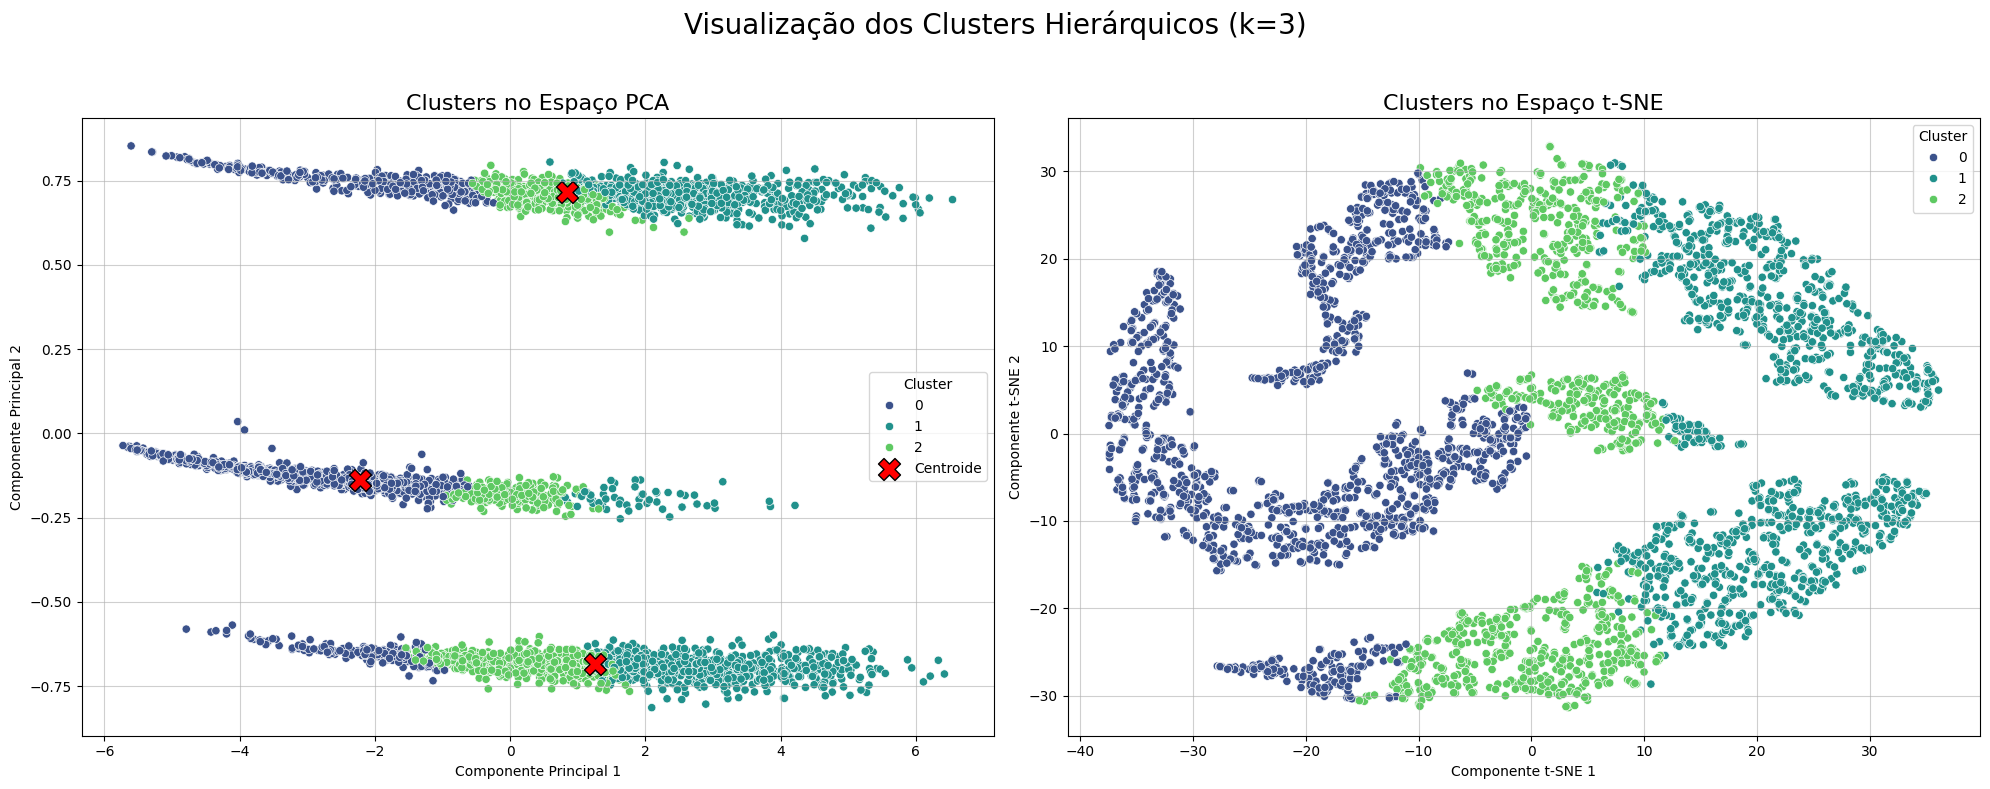

In [72]:
df_plot_hierarchical = pd.DataFrame()
df_plot_hierarchical['PCA1'] = coordenadas_pca[:, 0]
df_plot_hierarchical['PCA2'] = coordenadas_pca[:, 1]
df_plot_hierarchical['TSNE1'] = coordenadas_tsne[:, 0]
df_plot_hierarchical['TSNE2'] = coordenadas_tsne[:, 1]
df_plot_hierarchical['Cluster'] = pd.Categorical(hierarchical_labels)


# --- 2. CRIA√á√ÉO DOS GR√ÅFICOS ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Visualiza√ß√£o dos Clusters Hier√°rquicos (k=3)', fontsize=20)

# PCA
sns.scatterplot(
    data=df_plot_hierarchical,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    ax=axes[0]
)
# Centroides
centroids_pca = df_clusters.groupby('Cluster')[['PCA1', 'PCA2']].mean()
axes[0].scatter(
    centroids_pca['PCA1'], centroids_pca['PCA2'],
    marker='X', s=250, c='red', edgecolor='black', label='Centroide'
)

axes[0].set_title('Clusters no Espa√ßo PCA', fontsize=16)
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')
axes[0].grid(True, alpha=0.6)
axes[0].legend(title='Cluster')


# t-SNE
sns.scatterplot(
    data=df_plot_hierarchical,
    x='TSNE1',
    y='TSNE2',
    hue='Cluster',
    palette='viridis',
    ax=axes[1]
)
axes[1].set_title('Clusters no Espa√ßo t-SNE', fontsize=16)
axes[1].set_xlabel('Componente t-SNE 1')
axes[1].set_ylabel('Componente t-SNE 2')
axes[1].grid(True, alpha=0.6)
axes[1].legend(title='Cluster')


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## An√°lise dos Cluster com o Target Rings

In [73]:
# Usando o df_clean por ser o dataset original tratado sem os ru√≠dos
df_clean['Cluster'] = hierarchical_labels

# Agrupamos por cluster e calculamos a m√©dia das features num√©ricas
numeric_cols = df_clean.select_dtypes(include=['number']).columns
display(df_clean.groupby('Cluster')[numeric_cols].mean().round(2))

print("\n--- An√°lise Detalhada da Idade (Rings) por Cluster ---")
display(df_clean.groupby('Cluster')['Rings'].describe().round(2))

Length  Diameter  Height  WholeWeight  ShuckedWeight  VisceraWeight  \
Cluster                                                                        
0          0.41      0.31    0.10         0.36           0.16           0.08   
1          0.64      0.50    0.17         1.32           0.58           0.29   
2          0.55      0.43    0.15         0.82           0.35           0.18   

         ShellWeight  Rings  Cluster  
Cluster                               
0               0.11   8.06      0.0  
1               0.37  11.43      1.0  
2               0.24  10.82      2.0


--- An√°lise Detalhada da Idade (Rings) por Cluster ---


count   mean   std  min   25%   50%   75%   max
Cluster                                                  
0        1563.0   8.06  2.32  3.0   7.0   8.0   9.0  21.0
1        1352.0  11.43  2.90  6.0  10.0  11.0  12.0  29.0
2        1109.0  10.82  3.03  6.0   9.0  10.0  12.0  26.0

### üß© Conclus√£o da Clusteriza√ß√£o Hier√°rquica

A **clusteriza√ß√£o hier√°rquica** aplicada sobre os abalones revelou agrupamentos coerentes com a vari√°vel **target** (rings), que conseguiu atribuir que: quanto maior e mais pesado o abalone, mais velho ele ser√°.

As interpreta√ß√µes dos clusters foram as seguintes:

- üü¶ **Cluster 0**: Representa os **abalones mais jovens**, com **menor porte f√≠sico** e **peso mais leve**.
- üü¢ **Cluster 2**: Abrange os **abalones intermedi√°rios**, situando-se entre os extremos de idade e caracter√≠sticas f√≠sicas.
- üî∑ **Cluster 1**: Representa os **abalones mais velhos**, caracterizados por **maior tamanho e peso**.

> üìå Os resultados apresentados mostram que a Clusteriza√ß√£o Hier√°rquica foi bem sucedida, encontrando padr√µes que diferenciam as idades dos abalones.


## Comparativo Final das M√©tricas

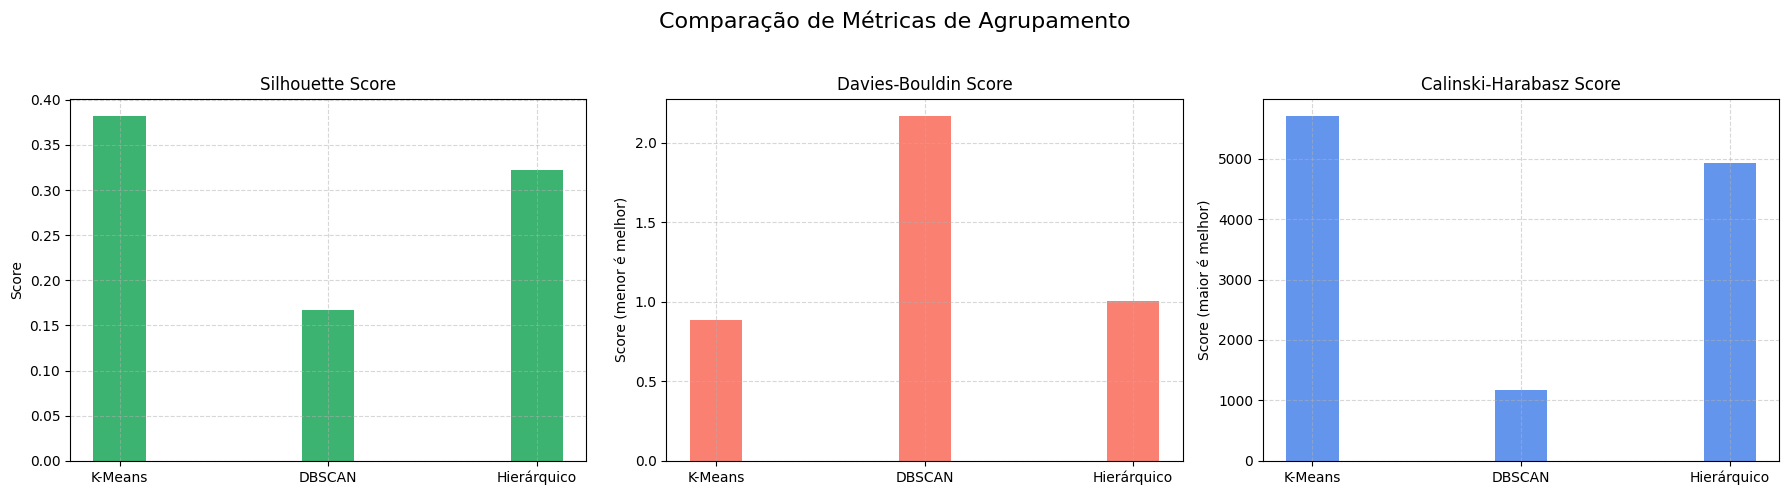

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Dados das m√©tricas
metodos = ['K-Means', 'DBSCAN', 'Hier√°rquico']

silhouette = [0.382, 0.1667, 0.3225]
davies_bouldin = [0.887, 2.1691, 1.0034]
calinski_harabasz = [5706.627, 1167.07, 4928.96]

# Configura√ß√µes do gr√°fico
x = np.arange(len(metodos))
largura = 0.25

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Compara√ß√£o de M√©tricas de Agrupamento', fontsize=16)

# Silhouette Score
axs[0].bar(x, silhouette, width=largura, color='mediumseagreen')
axs[0].set_title('Silhouette Score')
axs[0].set_xticks(x)
axs[0].set_xticklabels(metodos)
axs[0].set_ylabel('Score')
axs[0].grid(True, linestyle='--', alpha=0.5)

# Davies-Bouldin Score
axs[1].bar(x, davies_bouldin, width=largura, color='salmon')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xticks(x)
axs[1].set_xticklabels(metodos)
axs[1].set_ylabel('Score (menor √© melhor)')
axs[1].grid(True, linestyle='--', alpha=0.5)

# Calinski-Harabasz Score
axs[2].bar(x, calinski_harabasz, width=largura, color='cornflowerblue')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xticks(x)
axs[2].set_xticklabels(metodos)
axs[2].set_ylabel('Score (maior √© melhor)')
axs[2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
